# Import modules

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import timedelta
import pyfolio as pf
import yfinance as yf 

/var/folders/tx/l2m8lfrx6wb9kp7z6_h_xgyh0000gn/T/ipykernel_41793/3663117674.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


# Read price data

In [2]:
# start="1982-04-09"
start = "1993-01-29"
end="2023-04-09"

aapl_data = yf.download(tickers="AAPL",interval='1d', start=start, end=end , auto_adjust=True)
spy_data = yf.download(tickers="SPY", interval='1d', start=start, end=end, auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## split data into train and test sets

In [3]:
t = .9
split = int(t*len(aapl_data))

train_aapl = aapl_data[:split]
test_aapl = aapl_data[split:]

train_spy = spy_data[:split]
test_spy = spy_data[split:]

In [4]:
test_aapl.tail()

,Open,High,Low,Close,Volume
Date,,,,,
2023-03-31,162.440002,165.000000,161.910004,164.899994,68694700
2023-04-03,164.270004,166.289993,164.220001,166.169998,56976200
2023-04-04,166.600006,166.839996,165.110001,165.630005,46278300
2023-04-05,164.740005,165.050003,161.800003,163.759995,51511700
2023-04-06,162.429993,164.960007,162.000000,164.660004,45390100


# Backtest and model combination

In [5]:
# function for performance analysis
def trade_analytics(trade_logs_file, price_data):
    """
    The analysis of trade performance is done in this function
    """

    # Read the trade logs file
    trade_logs = pd.read_pickle(trade_logs_file)
    # rename columns and index
    trade_logs.columns = ['Time', 'position', 'trade_num']
    trade_logs = trade_logs.set_index('Time')

    # Join the trade logs and the price dataframe
    trade_analytics = trade_logs.join(price_data)

    # Calculate the percentage change on the stock itself
    trade_analytics['percent_change'] = trade_analytics.Close.pct_change()

    # Calculate the strategy returns
    trade_analytics['rl_strategy_returns'] = trade_analytics['percent_change'] * \
        trade_analytics['position'].shift(1)
    return trade_analytics

In [6]:
# Populating data from the agents trainings
rl_agent_returns = pd.DataFrame()
num_of_agents = 6

for n in range(1, num_of_agents):
    rl_agent_returns['rl_agent_'+str(n)] = trade_analytics(
        'trade_logs_aapl_'+str(n)+'.bz2', aapl_data)['rl_strategy_returns']

In [7]:
rl_agent_returns

,rl_agent_1,rl_agent_2,rl_agent_3,rl_agent_4,rl_agent_5
Time,,,,,
1994-04-06,NaN,NaN,NaN,NaN,NaN
1994-04-07,-0.003731,-0.003731,0.003731,-0.003731,0.003731
1994-04-08,0.003745,0.003745,0.000000,0.003745,-0.003745
1994-04-11,0.000000,0.000000,0.000000,0.000000,-0.000000
1994-04-12,0.044777,-0.044777,-0.044777,0.044777,0.044777
...,...,...,...,...,...
2018-04-18,0.002244,-0.000000,-0.000000,-0.002244,0.002244
2018-04-19,0.028340,0.028340,0.028340,-0.000000,0.028340
2018-04-20,0.040972,-0.000000,-0.000000,-0.000000,0.040972


In [10]:
# actual aapl returns

temp = pd.DataFrame(index=rl_agent_returns.index)
aapl_ret = temp.merge(train_aapl.Close.pct_change(), left_index=True, right_index=True, how='left')

In [11]:
# Using all the agents for making the strategy
selected_agents = rl_agent_returns

In [12]:
aapl_ret

,Close
Time,
1994-04-06,0.000000
1994-04-07,-0.003731
1994-04-08,0.003745
1994-04-11,0.000000
1994-04-12,-0.044777
...,...
2018-04-18,-0.002244
2018-04-19,-0.028340
2018-04-20,-0.040972


# selecting the agents

In [83]:
# Using all the agents for making the strategy
selected_agents = rl_agent_returns

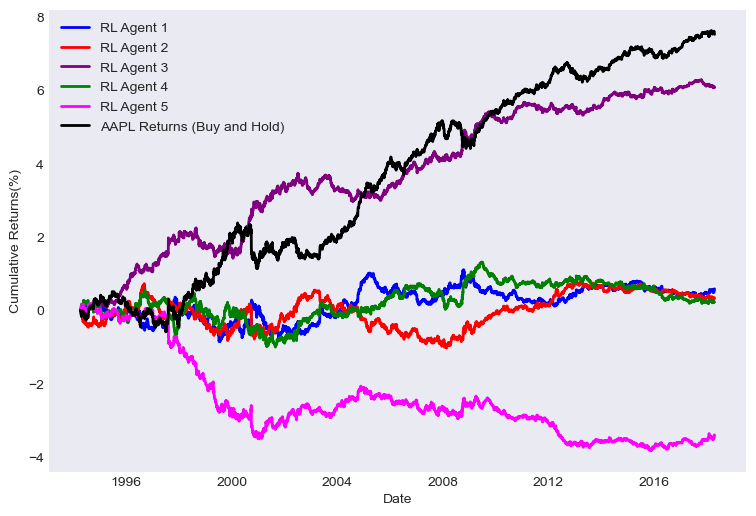

In [13]:
# plotting individual agent's performance and the buy hold strategy
fig, axl = plt.subplots()
fig.set_size_inches(9,6)    
plt.rcParams['lines.linewidth'] = 2
axl.plot(selected_agents.index, selected_agents.loc[:,'rl_agent_1'].cumsum(),'-', color='blue', label='RL Agent 1')
axl.plot(selected_agents.index, selected_agents.loc[:,'rl_agent_2'].cumsum(),'-', color='red', label='RL Agent 2')
axl.plot(selected_agents.index, selected_agents.loc[:,'rl_agent_3'].cumsum(),'-',color='purple', label='RL Agent 3')
axl.plot(selected_agents.index, selected_agents.loc[:,'rl_agent_4'].cumsum(),'-',color='green', label='RL Agent 4')
axl.plot(selected_agents.index, selected_agents.loc[:,'rl_agent_5'].cumsum(),'-',color='magenta', label='RL Agent 5')
axl.plot(aapl_ret.index, aapl_ret.cumsum(),'-', color='black', label='AAPL Returns (Buy and Hold)')
axl.legend(frameon=True)
axl.legend(loc='best')
axl.set_xlabel('Date')
axl.set_ylabel('Cumulative Returns(%)')
axl.grid(False)

In [14]:
# calculate the Sharpe Ratio of the returns

def sharpe_ratios(data_frame, risk_free_rate=0.0, sample_frequency=252.0):
    excess_returns = data_frame - risk_free_rate
    mean_excess_returns = excess_returns.mean()
    std_excess_returns = excess_returns.std()
    sharpe_ratios = np.sqrt(sample_frequency) * mean_excess_returns / std_excess_returns

    return sharpe_ratios

sharpe_ratio_values = sharpe_ratios(selected_agents)
print(sharpe_ratio_values)

rl_agent_1    0.065570
rl_agent_2    0.039085
rl_agent_3    0.710045
rl_agent_4    0.026267
rl_agent_5   -0.382366
dtype: float64


In [15]:
# calculate the Sharpe Ratio of the buy and hold

sharpe_ratios(aapl_ret)

Close    0.697999
dtype: float64

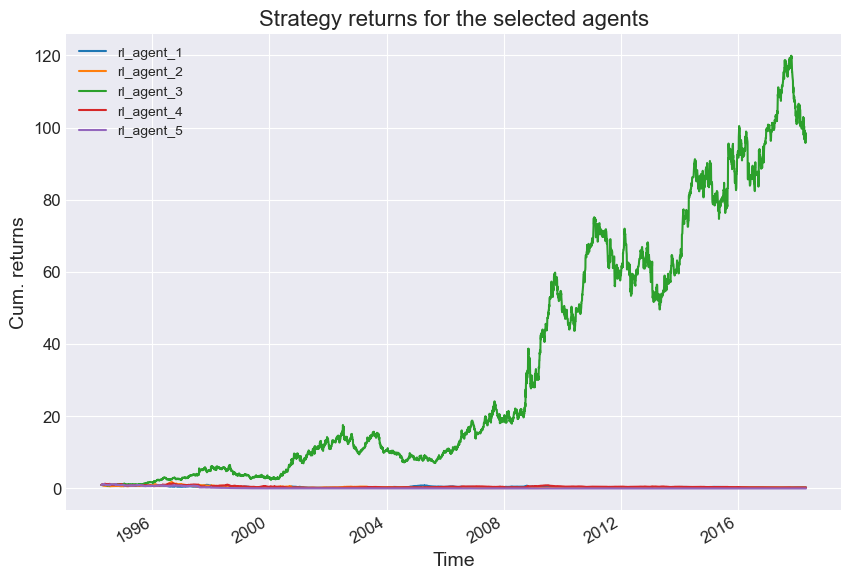

In [88]:
# Plotting individual agent's performance
(selected_agents+1).cumprod().plot(figsize=(10, 7))
plt.legend()
plt.ylabel('Cum. returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Strategy returns for the selected agents', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Get the agent's rolling performance

We calculate and plot the positive rolling returns for the agents. The rolling window is initially chosen as 30000 bars and can be changed by you.

Negative returns are omitted (by setting it to 0) as they will result in incorrect weight allocation of the agents in the strategy. 

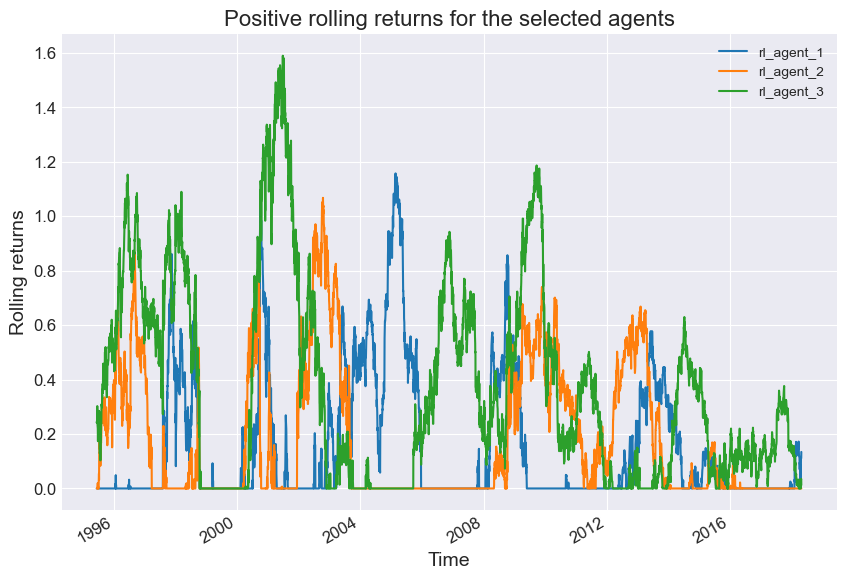

In [76]:
# Positive rolling returns for the agents
roll_returns_df = selected_agents.rolling(window=300).sum()
roll_returns_df[roll_returns_df < 0] = 0


roll_returns_df.plot(figsize=(10, 7))
plt.legend()
plt.ylabel('Rolling returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Positive rolling returns for the selected agents', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Allocate portfolio weight based on the performance

We calculate and plot the weight allocation of the agents in the strategy.

The weight allocation is updated every 1500 data bars in this model solution. You can tweak this parameter and analyse the returns further.

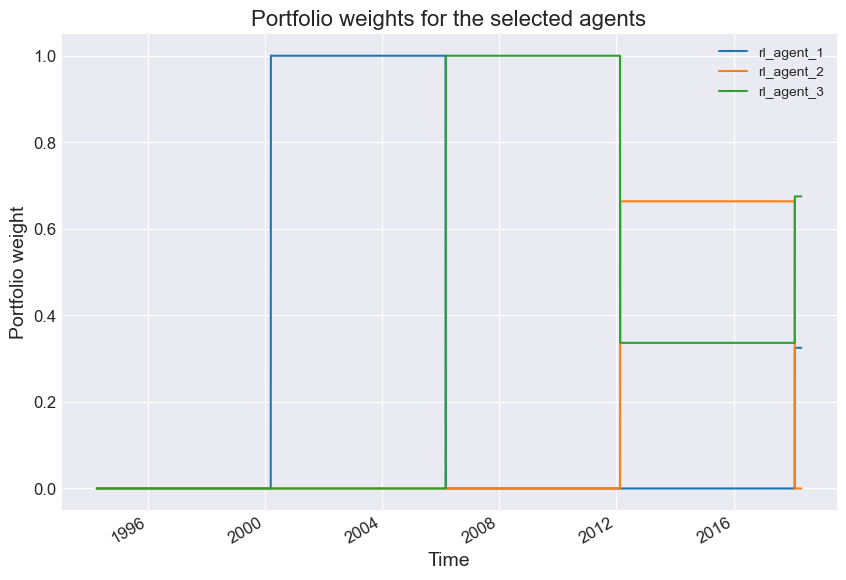

In [77]:
# Weight allocation of the agents on the basis of the positive rolling returns
wt_df = roll_returns_df.div(roll_returns_df.sum(axis=1), axis='rows').fillna(0)
wt_df.loc[~wt_df.index.isin(wt_df[::1500].index)] = np.nan
wt_df = wt_df.fillna(method='ffill')

# Plotting weights of the individual agents
wt_df.plot(figsize=(10, 7))
plt.legend()
plt.ylabel('Portfolio weight', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Portfolio weights for the selected agents', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Performance analysis

The strategy returns are then plotted against the selected agents for comparison.

We use pyfolio package to generate more performance metrics

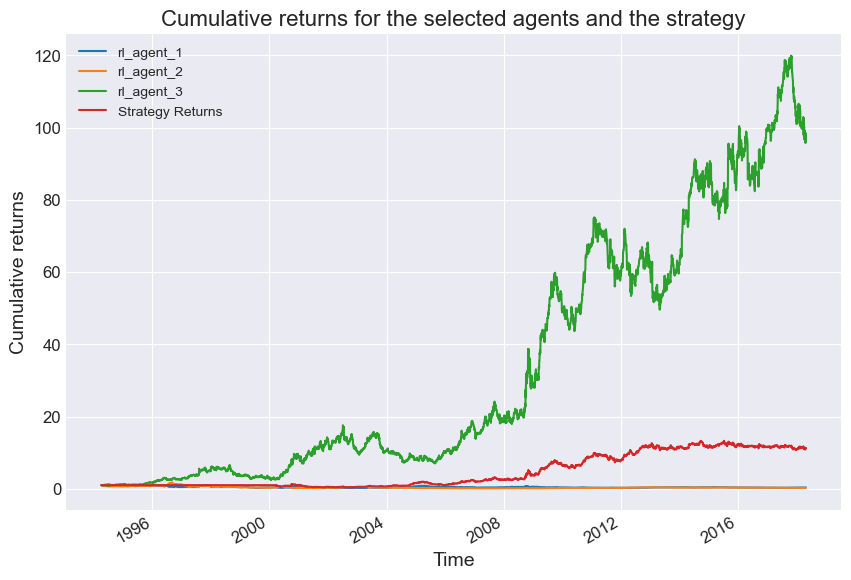

In [78]:
strategy_returns = (selected_agents*wt_df.shift(1)).dropna().sum(axis=1)
(selected_agents+1).cumprod().plot(figsize=(10, 7))

# Plotting strategy along with the individual agents
(strategy_returns+1).cumprod().plot(label='Strategy Returns', figsize=(10, 7))
plt.legend()
plt.ylabel('Cumulative returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Cumulative returns for the selected agents and the strategy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

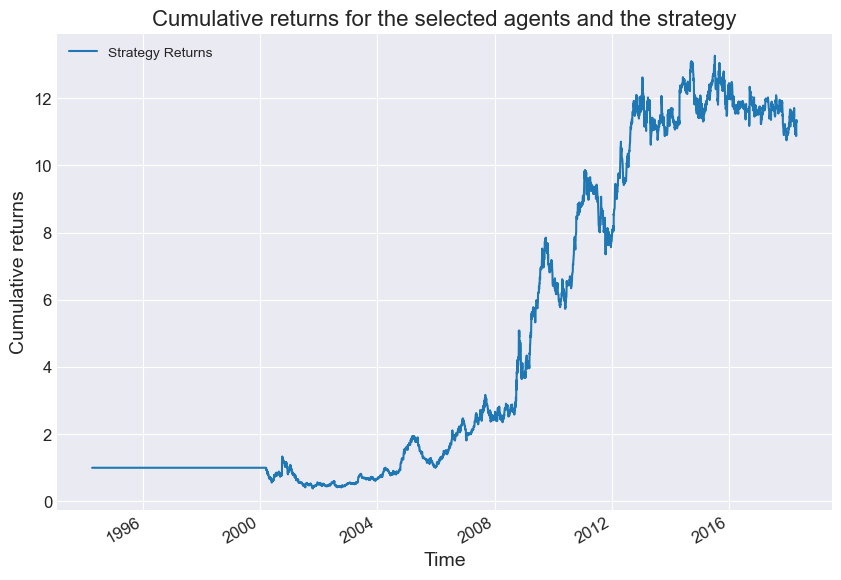

In [79]:
# Plotting strategy along with the individual agents
(strategy_returns+1).cumprod().plot(label='Strategy Returns', figsize=(10, 7))
plt.legend()
plt.ylabel('Cumulative returns', fontsize=14)
plt.xlabel('Time', fontsize=14)
plt.title('Cumulative returns for the selected agents and the strategy', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
pf.create_simple_tear_sheet(strategy_returns.resample('1D').sum())

# Performance on the test set

Here we need to load the weights of the best agents based on its performance and use that agent to  to make decisions (take actions) on the test data